In [1]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
from math import *
from PIL import Image
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics import Accuracy, Recall, F1Score

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 # Set to your device
torch.set_float32_matmul_precision('medium')

In [2]:
train_dfs= pd.read_pickle("./data/train_data.pickle")
test_dfs= pd.read_pickle("./data/test_data.pickle")
val_dfs= pd.read_pickle("./data/val_data.pickle")

In [3]:
# CLASS AND FUNCTIONS FOR DATALOADER CREATION

class OCData(Dataset):
    # Dataset Class
    def __init__(self, input, output, index, means, stds, transform=None):
        self.input = input
        self.output = output
        self.transform = transform
        self.index = index
        self.means = means
        self.stds = stds

    def __len__(self):
        return len(self.output)

    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.output[idx]
        z = self.index[idx]

        x = (x-self.means)/self.stds
        # If there is a transform, apply it here to your sample
        if self.transform is not None:
            x, y = self.transform(x,y)
        x = torch.tensor(x,dtype=torch.float32).to(device=device)           
        return x,y,z
    
def object_distance(map_layout, player, target):
    #Closest Object
    dist = len(map_layout)+len(map_layout[0])+1
    object_pos = None
    for row_idx in range(len(map_layout)):
        for col_idx in range(len(map_layout[0])):
            if map_layout[row_idx][col_idx]==target:
                temp_dist = abs(player[0]-col_idx)+abs(player[1]-row_idx)
                if temp_dist<dist:
                    object_pos = (col_idx,row_idx)
                    dist = temp_dist
                elif temp_dist==dist:
                    if np.random.rand()>0.5:
                        object_pos = (col_idx,row_idx)
    return object_pos

def encode_mlp(dfs,step=1):
    #Fixed sized inputs for NN
    L = len(dfs)
    input_list = [] 
    output_list = [] 
    index_list = []
    
    # Processing into array for NN
    for i in range(0,L,step):
        row = dfs.iloc[i]
        ja = row['joint_action']
        ja = ja.replace("\'","\"")
        y_act = json.loads(ja)
        player_idx = row['player_idx']

        # Action / Output / GT
        y_row = y_act[player_idx]
        y=-1
        if y_row == 'INTERACT':
            y=0
        elif y_row[0]==1:
            y=1
        elif y_row[0]==-1:
            y=2
        elif y_row[1]==1:
            y=3
        elif y_row[1]==-1:
            y=4
        else:
            print("Unknown Action", y, i, player_idx, y_act)
            continue
        
        # Input Data 
        # 0 - P2 PosX (r)
        # 1 - P2 PosY (r)
        # 2 - P1 O1
        # 3 - P1 O2
        # 4 - P1 onion
        # 5 - P1 dish
        # 6 - P1 soup
        # 7 - P2 O1
        # 8 - P2 O2
        # 9 - P2 onion
        # 10 - P2 dish
        # 11 - P2 soup
        # 12 - TP PosX (r)
        # 13 - TP PosY (r)
        # 14 - TO PosX (r)
        # 15 - TO PosY (r)
        # 16 - TD PosX (r)
        # 17 - TD PosY (r)
        # 18 - TS PosX (r)
        # 19 - TS PosY (r)


        x = np.zeros(20)
        state = json.loads(row['state'])
        players = [state['players'][player_idx%2], state['players'][(player_idx+1)%2]]
        posX = players[0]['position'][0]
        posY = players[0]['position'][1]

        #Relative Position of P2
        x[0] = players[1]['position'][0] - posX
        x[1] = players[1]['position'][1] - posY

        for j in range(2):
            player = players[j]

            #Orientation
            x[2+2*j]=(player['orientation'][0])
            x[3+2*j]=(player['orientation'][1])

            #Held object converter
            if player["held_object"]!=None:
                if player["held_object"]['name'] == "onion":
                    x[6+3*j]=1
                elif player["held_object"]['name'] == "dish":
                    x[7+3*j]=1
                elif player["held_object"]['name'] == "soup":
                    x[8+3*j]=1
                else:
                    print("Unknown Item", player["held_object"]['name'])
        
        #World Data - 8 (2 per target)
        map_layout = row['layout']
        map_layout = map_layout.replace("\'","\"")
        map_layout = json.loads(map_layout)
        
        target_list = ['P','O','D','S']
        for target_idx in range(len(target_list)):
            target = target_list[target_idx]
            target_pos = object_distance(map_layout, (posX,posY), target)
            if target_pos is None:
                print("Not found error", target)
            x[12+2*target_idx]=(target_pos[0]-posX)
            x[13+2*target_idx]=(target_pos[1]-posY)
        
        
        input_list.append(x)
        output_list.append(y)
        index_list.append(row['Unnamed: 0'])

    return input_list, output_list, index_list
    

In [4]:
# TRAIN AND TEST TRANSFORMS
def flip_mlp(x,y,axis=0):
    # Input Data 
    # 0 - P2 PosX (r)
    # 1 - P2 PosY (r)
    # 2 - P1 O1
    # 3 - P1 O2
    # 4 - P1 onion
    # 5 - P1 dish
    # 6 - P1 soup
    # 7 - P2 O1
    # 8 - P2 O2
    # 9 - P2 onion
    # 10 - P2 dish
    # 11 - P2 soup
    # 12 - TP PosX (r)
    # 13 - TP PosY (r)
    # 14 - TO PosX (r)
    # 15 - TO PosY (r)
    # 16 - TD PosX (r)
    # 17 - TD PosY (r)
    # 18 - TS PosX (r)
    # 19 - TS PosY (r)
    
    idx0_list = [0,12,14,16,18,2,7]

    for idx in idx0_list:
        x[idx+axis] = -x[idx+axis]
    
    if axis==0:
        if y==1:
            y=2
        elif y==2:
            y=1
    elif axis==1:
        if y==3:
            y=4
        elif y==4:
            y=3

    return x,y

def rotate_mlp(x,y):
    # Input Data 
    # 0 - P2 PosX (r)
    # 1 - P2 PosY (r)
    # 2 - P1 O1
    # 3 - P1 O2
    # 4 - P1 onion
    # 5 - P1 dish
    # 6 - P1 soup
    # 7 - P2 O1
    # 8 - P2 O2
    # 9 - P2 onion
    # 10 - P2 dish
    # 11 - P2 soup
    # 12 - TP PosX (r)
    # 13 - TP PosY (r)
    # 14 - TO PosX (r)
    # 15 - TO PosY (r)
    # 16 - TD PosX (r)
    # 17 - TD PosY (r)
    # 18 - TS PosX (r)
    # 19 - TS PosY (r)
    
    idx0_list = [0,12,14,16,18,2,7]

    for idx in idx0_list:
        x[idx],x[idx+1] = (x[idx+1],x[idx])
    
    if y==2:
        y=4
    elif y==4:
        y=2
    elif y==3:
        y=1
    elif y==1:
        y=3

    return x,y
    
def train_transform(x,y):
    rand1 = np.random.rand()
    rand2 = np.random.rand()
    rand3 = np.random.rand()
    if rand1>0.5:
        x,y = flip_mlp(x,y,axis=0)
    if rand2>0.5:
        x,y = flip_mlp(x,y,axis=1)
    if rand3>0.5:
        x,y = rotate_mlp(x,y)
    return x,y

In [5]:
# Create Dataloaders
def create_loader(train_dfs, val_dfs, test_dfs):
    #Training Dataloader
    input_list, output_list, index_list = encode_mlp(train_dfs)
    input_arr = np.array(input_list)
    train_means = np.mean(input_arr,axis=0)
    train_stds = np.std(input_arr,axis=0)

    idx0_list = [0,12,14,16,18,2,7]
    for idx in idx0_list:
        shared_mean = np.mean(input_arr[:,idx:idx+2])
        train_means[idx] = shared_mean
        train_means[idx+1] = shared_mean

        shared_std = np.std(input_arr[:,idx:idx+2])
        train_stds[idx] = shared_std
        train_stds[idx+1] = shared_std

    print(train_stds, train_means,input_arr.shape)
    train_dataset = OCData(input_list,output_list,index_list, means = train_means, stds= train_stds,transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

    #Validation loader
    input_list, output_list, index_list = encode_mlp(val_dfs)
    val_dataset = OCData(input_list,output_list,index_list, means = train_means, stds= train_stds)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

    #Test loader
    input_list, output_list, index_list = encode_mlp(test_dfs)
    test_dataset = OCData(input_list,output_list,index_list, means = train_means, stds= train_stds)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

train_loader, valid_loader, test_loader = create_loader(train_dfs, val_dfs, test_dfs)

[1.97533113 1.97533113 0.70533977 0.70533977 0.74956428 0.65880144
 0.47293098 0.30603555 0.30603555 0.46530991 0.33996931 0.28412488
 1.57801477 1.57801477 1.62648379 1.62648379 1.99736763 1.99736763
 1.80110463 1.80110463] [-0.02115321 -0.02115321 -0.04995813 -0.04995813 -0.01636931 -0.06217801
  0.3377154   0.10459863  0.10459863  0.31700632  0.13336548  0.08857194
 -0.28960993 -0.28960993 -0.05696267 -0.05696267 -0.48832576 -0.48832576
  1.00719488  1.00719488] (39403, 20)


In [6]:
class Simple_MLP(pl.LightningModule):
    
    def __init__(self, num_classes=5, learning_rate=1.5e-3):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        
        # self.bn = nn.BatchNorm1d(20)
        # You will need to define your fully connected layer:
        self.fc1 = nn.Linear(20,64)
        self.fc2 = nn.Linear(64,48)
        self.fc3 = nn.Linear(48, num_classes)

        self.dropout = nn.Dropout(0.16)

        self.leaky_relu = nn.LeakyReLU()
        
        # Define your accuracies        
        self.train_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        
        
    def forward(self, x):

        x = torch.flatten(x,start_dim=1)
        # x = self.bn(x)
        x = self.dropout(x)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))

        return x
    
    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        acc = self.train_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        train_dict = {"train_loss": loss,
                    "train_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)
        acc = self.val_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        val_dict = {"val_loss": loss,
                    "val_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
    
        

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        
        self.test_accuracy.update(preds, y)
        acc = self.test_accuracy.compute()
        # Record accuracy and loss
        # Log anything you think necessary
        test_dict = {"test_loss": loss,
                    "test_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

        return preds, logits, x, y
    
    def predict_step(self, batch, batch_idx):
        x, y, z= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        return preds, logits, x, y, z

        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),self.learning_rate)
        return optimizer

    ##########
    # DATA RELATED HOOKS
    ##########

    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return valid_loader
    def test_dataloader(self):
        return test_loader

In [7]:
# Initialize the CNN model
max_epochs = 100 # Feel free to change this
model_cnn = Simple_MLP()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section/v1/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Call the Trainer and train the model
early_stopping = EarlyStopping('val_loss', patience = 10, mode = 'min')
trainer_task = pl.Trainer(
    accelerator="auto",
    devices=1, #if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[progress_bar_task, checkpoint_callback,early_stopping],
    logger=CSVLogger(save_dir="logs_task/v1/"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
# trainer_task.fit(model_cnn)

In [9]:
# torch.save(model_cnn,"./models/v1/model_1.pt")
# model_cnn = torch.load("./models/v1/model_1.pt")
model_cnn = Simple_MLP.load_from_checkpoint("./checkpoints_section/v1/epoch=83-step=13020.ckpt")

In [9]:
trainer_task.test(model_cnn,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\shelb\anaconda3\envs\srp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │            0.0            │
│         test_acc          │    0.6722849607467651     │
│         test_loss         │    0.9931233525276184     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9931233525276184,
  'test_acc': 0.6722849607467651,
  'epoch': 0.0}]

84


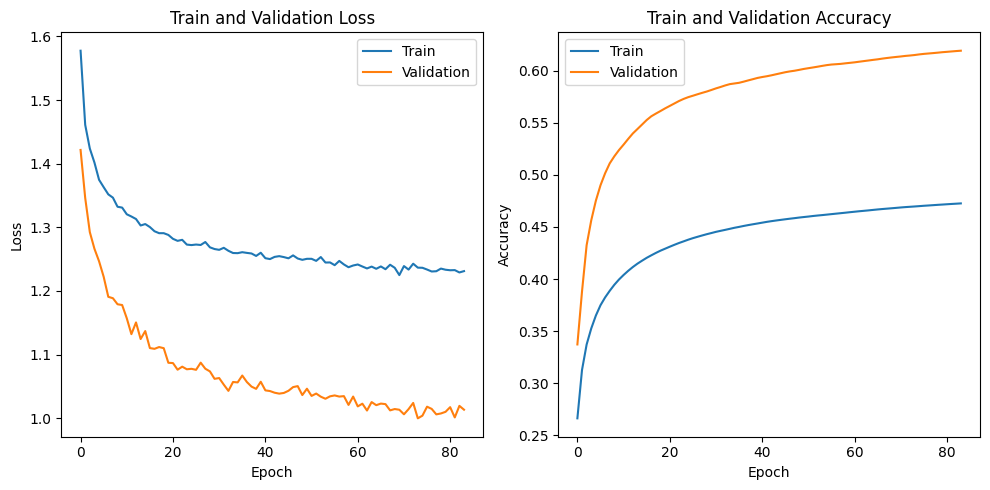

In [39]:
METRICS_PATH = "./logs_task/v1/lightning_logs/version_7"
metrics_task = pd.read_csv(METRICS_PATH + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

plt.rcParams["figure.figsize"] = (10, 5)

plt.subplot(1,2,1)
epochs = len(metrics_task)-1
print(epochs)
plt.plot(metrics_task["train_loss"][0:epochs-1])
plt.plot(metrics_task["val_loss"][0:epochs-1])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train and Validation Loss")
plt.legend(["Train", "Validation"]);

plt.subplot(1,2,2)

plt.plot(metrics_task["train_acc"][0:epochs-1])
plt.plot(metrics_task["val_acc"][0:epochs-1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Train and Validation Accuracy")
plt.legend(["Train", "Validation"]);

plt.tight_layout();

In [40]:
# Concatenate the predictions from multiple batches
model_cnn.eval()
predictions = trainer_task.predict(model_cnn,test_loader)

test_outputs = torch.cat([prediction[1] for prediction in predictions], dim=0)  # Concatenate model outputs
test_labels = torch.cat([prediction[3] for prediction in predictions], dim=0)  # Concatenate true labels
test_inputs = torch.cat([prediction[2] for prediction in predictions], dim=0)  # Concatenate input images
test_preds = torch.cat([prediction[0] for prediction in predictions], dim=0)#test_outputs.argmax(dim=1)  # Find the index of the maximum probability along the classes (predicted labels)
test_indices = torch.cat([prediction[4] for prediction in predictions], dim=0)  # Concatenate model outputs

Output()

c:\Users\dlars_vmeeupk\anaconda3\envs\ece4179\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


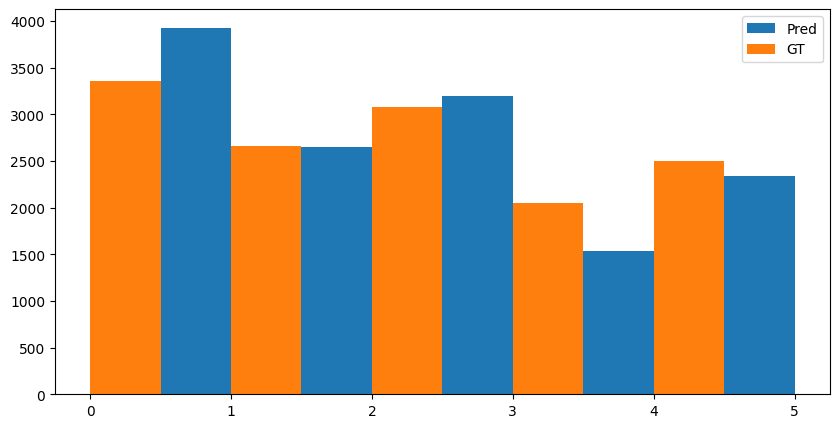

In [41]:
plt.hist(test_preds+0.5,bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],label="Pred");
plt.hist(test_labels,bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],label="GT");
plt.legend()
plt.show()

In [42]:
## Saliency map
label_list = ["P2_X", "P2_Y", "P1_O1","P1_O2","P1_Onion","P1_Dish", "P1_Soup", "P2_O1","P2_O2","P2_Onion","P2_Dish", "P2_Soup","TP_X","TP_Y","TO_X","TO_Y","TD_X","TD_Y","TS_X","TS_Y"]

def saliency(index,plot=False, save_plot=False):
    # Retrieve the input image, true label, model output, predicted label for the selected index
    pred = test_preds[index]
    label = test_labels[index]
    # output = test_outputs[index]
    image_original = test_inputs[index]
    test_index = test_indices[index]

    # Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
    image = image_original.unsqueeze(0)
    image.requires_grad = True

    # Compute the scores and gradients for the input image
    # To compute the scores, do a forward pass of the image and then take the argmax
    # Use this index to extract the score_max value from "scores"
    # Then perform a backward step so that it backpropagates the gradient
    scores = model_cnn.forward(image)
    score_max_index = torch.argmax(scores)
    score_max = scores[0, score_max_index]
    score_max.backward() # Do the backward step here for the gradient calculation

    # Calculate the saliency map by finding the maximum absolute gradient values across channels
    # You can use .abs() and torch.max()
    grad = image.grad
    grad_abs = torch.squeeze(grad.abs())

    # # Create a subplot to display the original image and saliency map side by side
    if plot or save_plot:
        actions_list = ["INT","Right","Left","Down","Up"]
        plt.close()
        plt.figure()
        plt.rcParams["figure.figsize"] = (10, 4)

        #Saliency Bar Graph
        plt.subplot(1,2,1)
        plt.bar(range(1,len(grad_abs)+1),grad_abs)
        plt.title(f"Saliency Analysis\n Pred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {test_index}")
        plt.xticks(ticks = range(1,len(grad_abs)+1),labels=label_list,rotation='vertical')

        #Original Image
        plt.subplot(1,2,2)
        image_disp = torchvision.io.read_image(f"./data/imgs/test/{label.item()}/{test_index}.png")
        image_disp_rgb = image_disp.permute(1,2,0)

        plt.title(f"Map: {test_index}")
        plt.axis('off')
        plt.imshow(image_disp_rgb)
        plt.tight_layout()

        if plot:
            plt.show()

        if save_plot:
            plt.savefig(fname=f"./results/v1/{test_index}.png")
        

    return grad_abs

In [43]:
# Plot saliency of a data point
# saliency(0,True)

# Get saliency stats and save results
grad_stats = []
for index in range(len(test_labels)):
    grad_stat = saliency(index, False, False)
    grad_stats.append(np.array(grad_stat))

np.save("./results/v1/stats.npy",np.array(grad_stats))

[11055  8915  1318  7221 11468  7540   664  6137  6833  8471  9449  7322
  8222  1182  7916  8060  7962 10682 10360  7644 11589 11600  9161  2431
   246  2558  3503  5682  3824  5883  5196 12198  1530 13507 10983  7307
  6784  4841 12107 10576     3  1282  1299 11148  6603  4467  3691 11278
  3315 10695 12092  8682  6763  4014  7068  3153  9047  9997  4212 12896
 11148 12485   625  3039  8165 11935  8953 13308 11865  9300 10285  2576
 12329 12216  5206  8108   986 11219  2351  5138  9813  9902  2530 12069
  6950 12423  3044  1731  1774  2607  3062 10484 10614  8879  9103  2594
    10  3356  5124  2130]


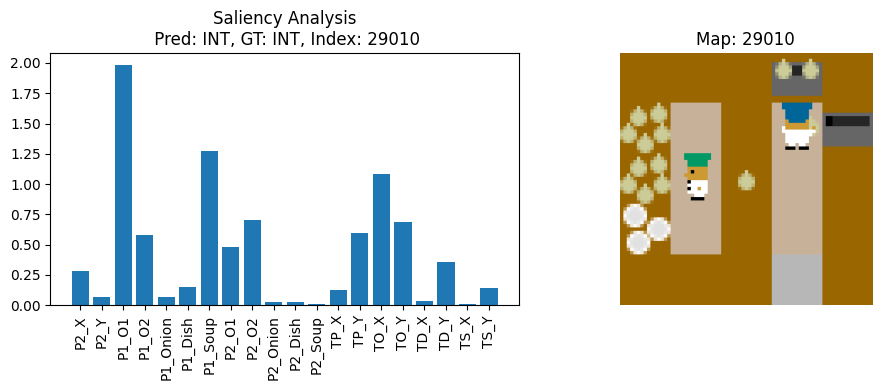

In [44]:
np.random.seed(1234)
results_indices = np.random.randint(0,len(test_dfs),size=100)
print(results_indices)

for index in results_indices:
    grad_stat = saliency(index, False, True)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


(13824, 20)
(200, 20)


  0%|          | 0/200 [00:00<?, ?it/s]

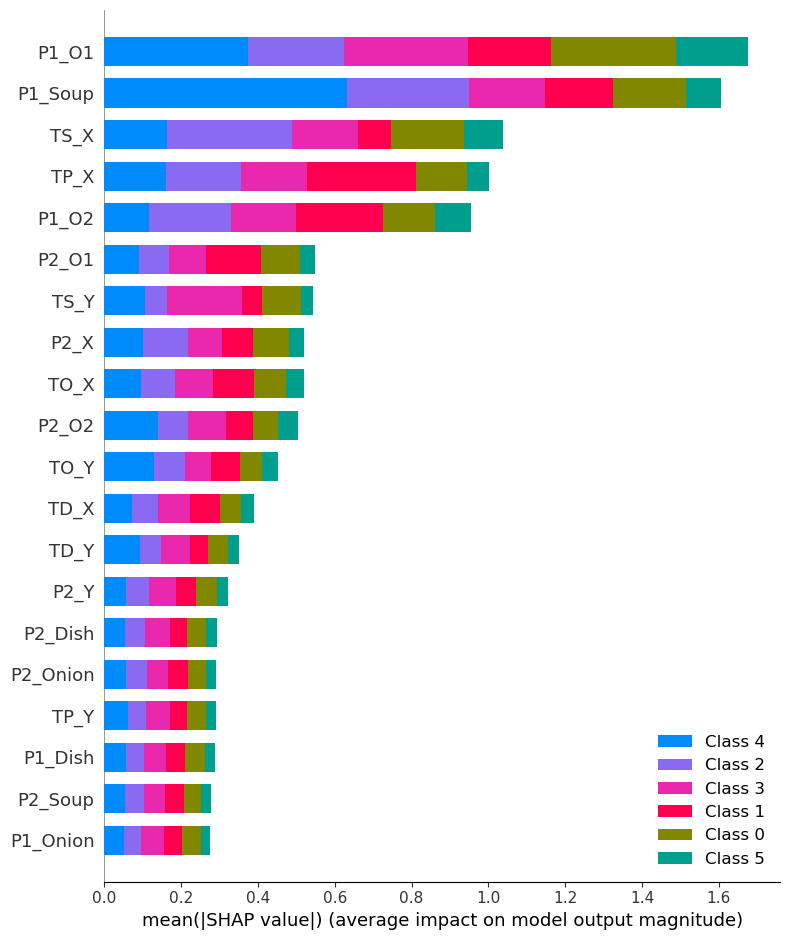

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


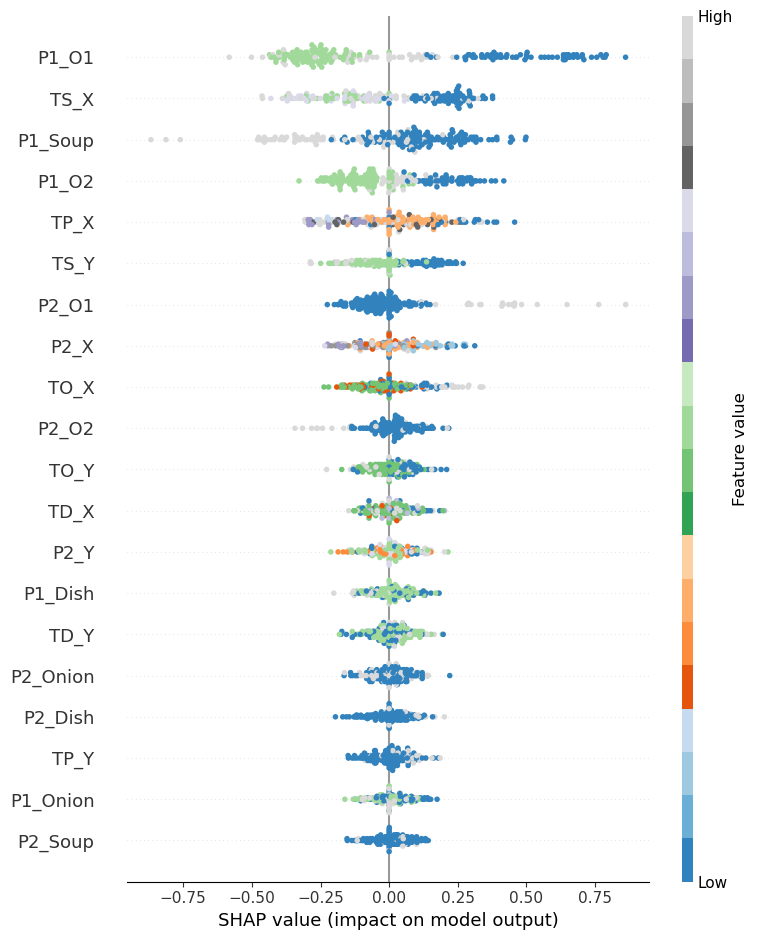

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


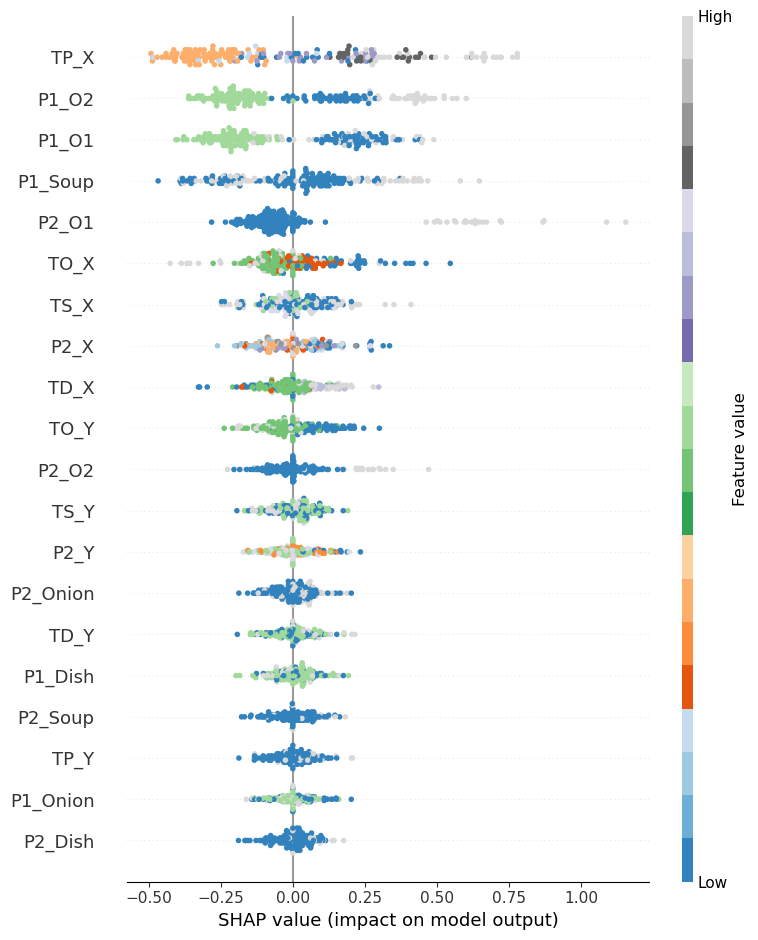

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


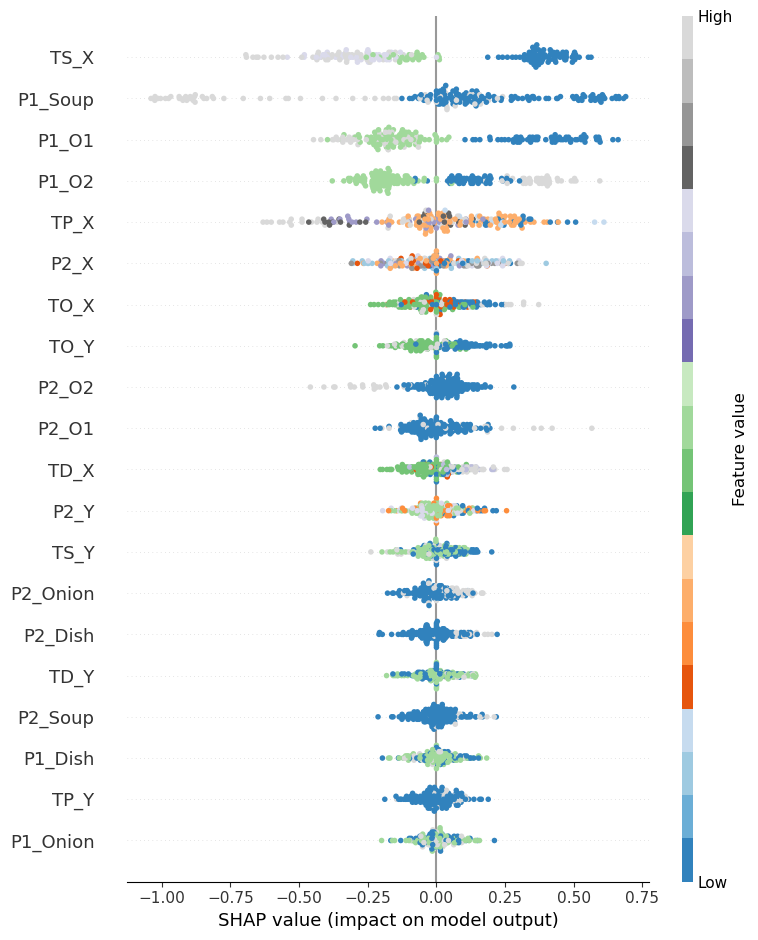

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


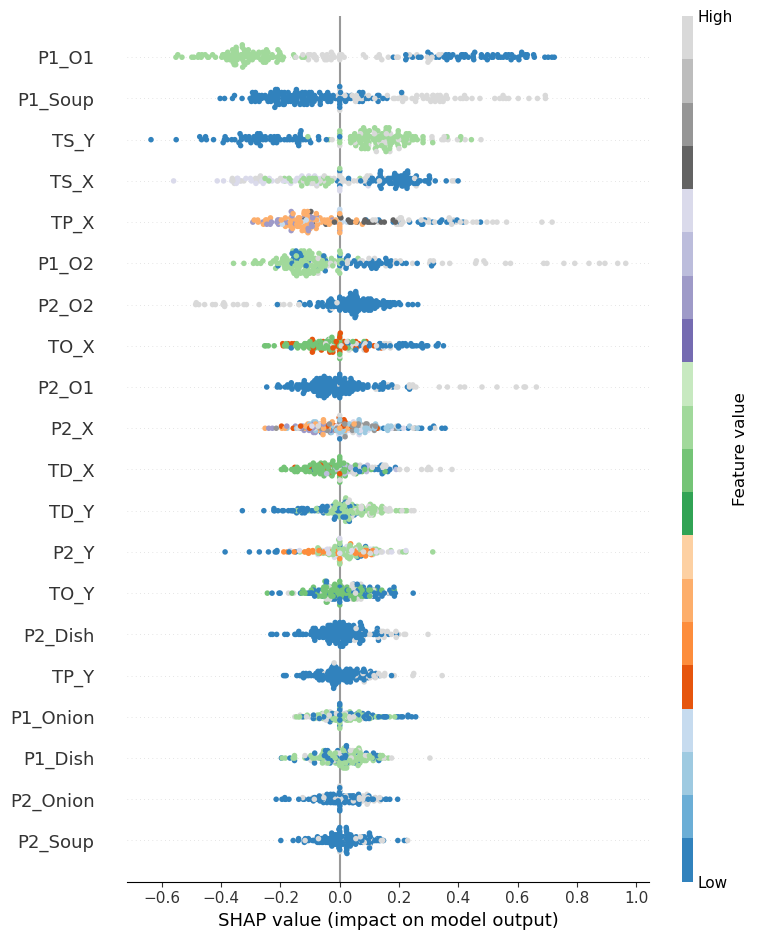

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


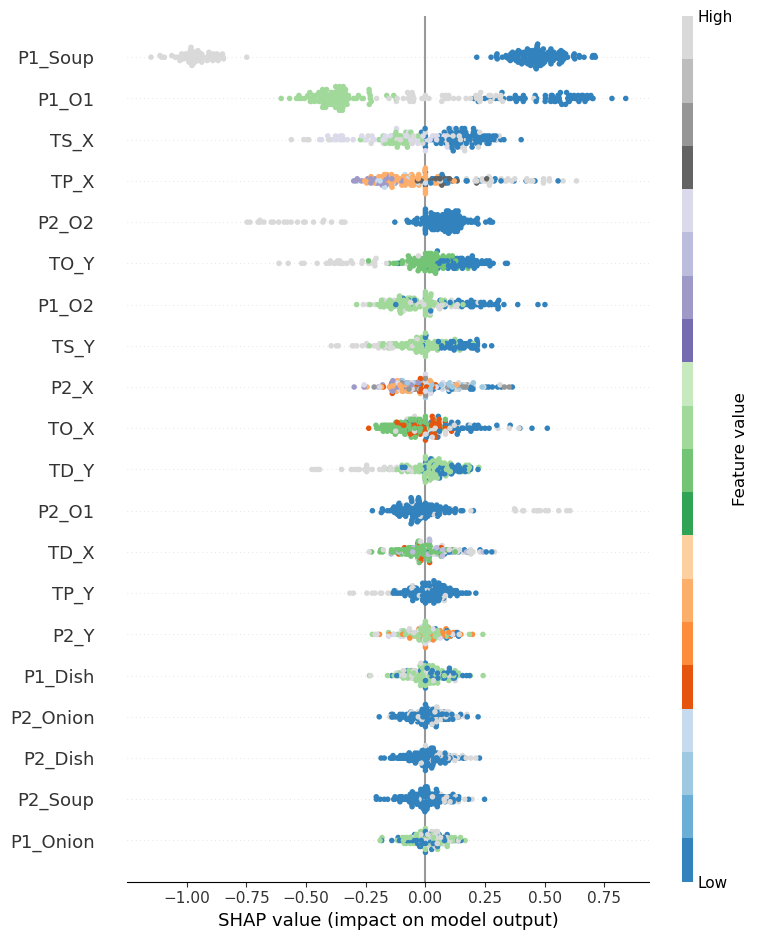

<Figure size 640x480 with 0 Axes>

In [10]:
from nn_metrics import *

mlp_label = ["P2_X", "P2_Y", "P1_O1","P1_O2","P1_Onion","P1_Dish", "P1_Soup", "P2_O1","P2_O2","P2_Onion","P2_Dish", "P2_Soup","TP_X","TP_Y","TO_X","TO_Y","TD_X","TD_Y","TS_X","TS_Y"]
shapley(model_cnn.to("cpu"),test_loader,mlp_label,True)